In [1]:
import os
from netCDF4 import Dataset
import numpy as np

# 1. Get the current working directory
current_dir = os.getcwd()

# 2. Build the paths relative to current_dir
directory_path = os.path.join(current_dir, "extracted")
output_directory = os.path.join(current_dir, "processed")

# 3. Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

print(f"Directory for .nc files: {directory_path}")
print(f"Directory for processed outputs: {output_directory}")

# Define a list of base filenames with a placeholder for the year
base_filenames = [
    "EDGAR_2024_GHG_CH4_{year}_bkl_AGRICULTURE_emi",
    "EDGAR_2024_GHG_CH4_{year}_bkl_AGRICULTURE_flx",
    "EDGAR_2024_GHG_CO2_{year}_bkl_AGRICULTURE_emi",
    "EDGAR_2024_GHG_CO2_{year}_bkl_AGRICULTURE_flx",
    "EDGAR_2024_GHG_CO2bio_{year}_bkl_AGRICULTURE_emi",
    "EDGAR_2024_GHG_CO2bio_{year}_bkl_AGRICULTURE_flx",
    "EDGAR_2024_GHG_GWP_100_AR5_GHG_{year}_bkl_AGRICULTURE_emi",
    "EDGAR_2024_GHG_GWP_100_AR5_GHG_{year}_bkl_AGRICULTURE_flx",
    "EDGAR_2024_GHG_N2O_{year}_bkl_AGRICULTURE_emi",
    "EDGAR_2024_GHG_N2O_{year}_bkl_AGRICULTURE_flx"
]

# Dictionary to store memory-mapped tensors for each dataset
emission_tensors = {}

# Loop through each base filename
for base_filename_template in base_filenames:
    print(f"🔍 Processing dataset template: {base_filename_template}")

    # Pre-allocate memory-mapped array: 24 years (2000-2023) × 12 months = 288 time steps
    tensor_shape = (288, 1800, 3600)  # (time, lat, lon)
    output_file = os.path.join(output_directory, f"{base_filename_template.replace('{year}', '2000_2023')}.dat")
    emissions_tensor = np.memmap(output_file, dtype='float32', mode='w+', shape=tensor_shape)

    index = 0  # Keeps track of where to insert the yearly data in the tensor

    # Loop through all years from 2000 to 2023
    for year in range(2000, 2024):
        filename = base_filename_template.format(year=year) + ".nc"
        file_path = os.path.join(directory_path, filename)

        # Check if the file exists
        if os.path.isfile(file_path):
            print(f"✅ Processing file for year {year}...")

            # Load the NetCDF file
            dataset = Dataset(file_path, mode="r")

            # Extract emissions or fluxes data
            variable_name = (
                "emissions" if "emissions" in dataset.variables
                else "fluxes" if "fluxes" in dataset.variables
                else None
            )

            if variable_name:
                data = dataset.variables[variable_name][:]

                # Convert MaskedArray to a regular numpy array if necessary
                if np.ma.isMaskedArray(data):
                    data = data.filled(0)

                # Validate the shape
                if data.shape == (12, 1800, 3600):
                    # Write directly into the memory-mapped array
                    emissions_tensor[index:index + 12, :, :] = data
                    index += 12
                else:
                    print(f"⚠️ Shape mismatch for year {year}, skipping.")
            else:
                print(f"⚠️ Neither 'emissions' nor 'fluxes' variable found in {filename}, skipping.")

            dataset.close()
        else:
            print(f"❌ File for year {year} does not exist, skipping.")

    # Flush changes to disk
    emissions_tensor.flush()
    emission_tensors[base_filename_template] = emissions_tensor
    print(f"💾 Saved memory-mapped tensor for {base_filename_template} at {output_file}\n")

# ✅ Summary of tensors created
print("\n📊 Summary of computed tensors:")
for dataset_name, tensor in emission_tensors.items():
    print(f"{dataset_name}: Shape {tensor.shape}, File: {tensor.filename}")


Directory for .nc files: c:\Users\XPS\Desktop\github_projects\CS229-Final-Project\EDGAR\extracted
Directory for processed outputs: c:\Users\XPS\Desktop\github_projects\CS229-Final-Project\EDGAR\processed
🔍 Processing dataset template: EDGAR_2024_GHG_CH4_{year}_bkl_AGRICULTURE_emi
✅ Processing file for year 2000...
✅ Processing file for year 2001...
✅ Processing file for year 2002...
✅ Processing file for year 2003...
✅ Processing file for year 2004...
✅ Processing file for year 2005...
✅ Processing file for year 2006...
✅ Processing file for year 2007...
✅ Processing file for year 2008...
✅ Processing file for year 2009...
✅ Processing file for year 2010...
✅ Processing file for year 2011...
✅ Processing file for year 2012...
✅ Processing file for year 2013...
✅ Processing file for year 2014...
✅ Processing file for year 2015...
✅ Processing file for year 2016...
✅ Processing file for year 2017...
✅ Processing file for year 2018...
✅ Processing file for year 2019...
✅ Processing file f

In [2]:
# ✅ Summary of tensors created
print("\n📊 Summary of computed tensors:")
for dataset_name, tensor in emission_tensors.items():
    print(f"{dataset_name}: Shape {tensor.shape}")


📊 Summary of computed tensors:
EDGAR_2024_GHG_CH4_{year}_bkl_AGRICULTURE_emi: Shape (288, 1800, 3600)
EDGAR_2024_GHG_CH4_{year}_bkl_AGRICULTURE_flx: Shape (288, 1800, 3600)
EDGAR_2024_GHG_CO2_{year}_bkl_AGRICULTURE_emi: Shape (288, 1800, 3600)
EDGAR_2024_GHG_CO2_{year}_bkl_AGRICULTURE_flx: Shape (288, 1800, 3600)
EDGAR_2024_GHG_CO2bio_{year}_bkl_AGRICULTURE_emi: Shape (288, 1800, 3600)
EDGAR_2024_GHG_CO2bio_{year}_bkl_AGRICULTURE_flx: Shape (288, 1800, 3600)
EDGAR_2024_GHG_GWP_100_AR5_GHG_{year}_bkl_AGRICULTURE_emi: Shape (288, 1800, 3600)
EDGAR_2024_GHG_GWP_100_AR5_GHG_{year}_bkl_AGRICULTURE_flx: Shape (288, 1800, 3600)
EDGAR_2024_GHG_N2O_{year}_bkl_AGRICULTURE_emi: Shape (288, 1800, 3600)
EDGAR_2024_GHG_N2O_{year}_bkl_AGRICULTURE_flx: Shape (288, 1800, 3600)


In [3]:
import os
import numpy as np

# Define the directory where the memory-mapped tensor will be saved
output_directory = os.path.join(current_dir, "processed")

os.makedirs(output_directory, exist_ok=True)

# Assuming this dictionary is already populated with numpy arrays
# Key format: 'EDGAR_2024_GHG_<Molecule>_{year}_bkl_AGRICULTURE_<Type>'
# Example entry: 'EDGAR_2024_GHG_CO2_{year}_bkl_AGRICULTURE_emi': np.array([...])

# Example placeholder (you already have this)
# emission_tensors = {
#     "EDGAR_2024_GHG_CO2_{year}_bkl_AGRICULTURE_emi": np.random.rand(288, 1800, 3600),
#     ...
# }

# Define mappings for molecules and data types
molecule_types = ["CH4", "CO2", "CO2bio", "GWP", "N2O"]
data_types = ["emi", "flx"]

# Create the memory-mapped array for the super tensor
super_tensor_shape = (len(molecule_types), len(data_types), 288, 1800, 3600)
super_tensor_file = os.path.join(output_directory, "super_emissions_tensor.dat")
super_tensor = np.memmap(super_tensor_file, dtype='float32', mode='w+', shape=super_tensor_shape)

# Populate the super tensor from the dictionary
for molecule_idx, molecule in enumerate(molecule_types):
    for data_type_idx, data_type in enumerate(data_types):
        # Construct the key pattern
        key = f"EDGAR_2024_GHG_{molecule}_{{year}}_bkl_AGRICULTURE_{data_type}" if molecule != "GWP" else f"EDGAR_2024_GHG_GWP_100_AR5_GHG_{{year}}_bkl_AGRICULTURE_{data}"

        # Retrieve the tensor from the dictionary
        if key in emission_tensors:
            data = emission_tensors[key]

            # Validate shape before insertion
            if data.shape == (288, 1800, 3600):
                # Insert data into the super tensor
                super_tensor[molecule_idx, data_type_idx, :, :, :] = data
                print(f"✅ Added {molecule} - {data_type} to super tensor.")
            else:
                print(f"⚠️ Shape mismatch for {key}: {data.shape}")
        else:
            print(f"❌ Data for {key} not found in the dictionary.")

# Flush changes to disk
super_tensor.flush()

# ✅ Summary of the final tensor
print(f"\n💾 Super tensor saved at: {super_tensor_file}")
print(f"🔢 Super tensor shape: {super_tensor.shape}")


✅ Added CH4 - emi to super tensor.
✅ Added CH4 - flx to super tensor.
✅ Added CO2 - emi to super tensor.
✅ Added CO2 - flx to super tensor.
✅ Added CO2bio - emi to super tensor.
✅ Added CO2bio - flx to super tensor.
❌ Data for EDGAR_2024_GHG_GWP_100_AR5_GHG_{year}_bkl_AGRICULTURE_[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0.

In [4]:
super_tensor.shape

(5, 2, 288, 1800, 3600)

In [5]:
super_tensor[:,:, 0:12, 700:1000, 1500:2000]

memmap([[[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            6.16830945e-01, 6.49426401e-01, 6.34646773e-01],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            6.35563076e-01, 6.65375948e-01, 6.65829837e-01],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            7.27511764e-01, 6.28405809e-01, 6.76479459e-01],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            2.45341611e+00, 3.99355841e+00, 4.20917559e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            3.11257148e+00, 4.36904144e+00, 4.35180998e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            4.12660980e+00, 4.61160231e+00, 4.63475513e+00]],

          [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            6.16830945e-01, 6.49426401e-01, 6.34646773e-01],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            6.35563076e-01, 6.65375

In [6]:
np.save("super_emissions_tensor", super_tensor)

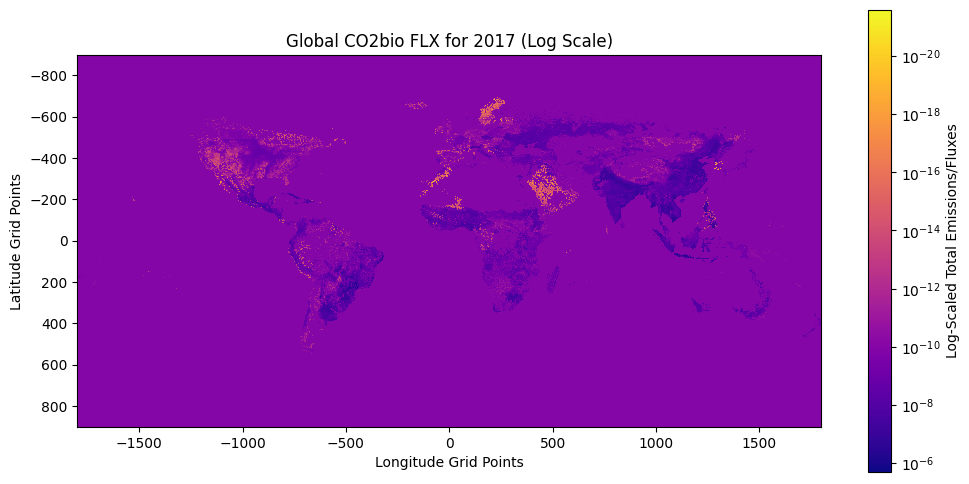

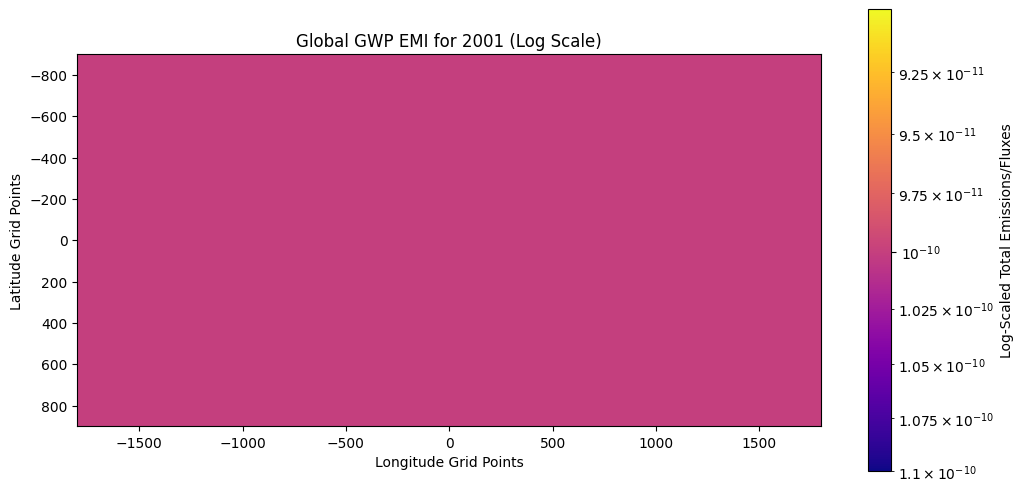

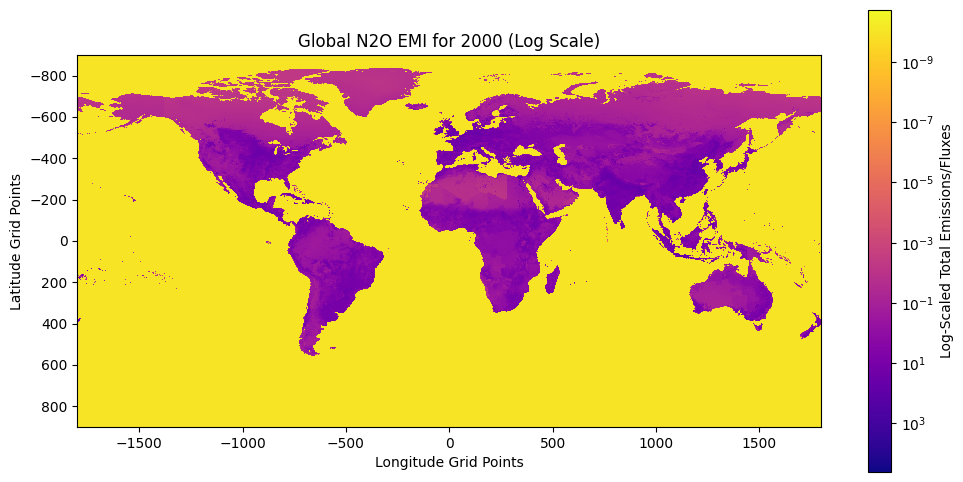

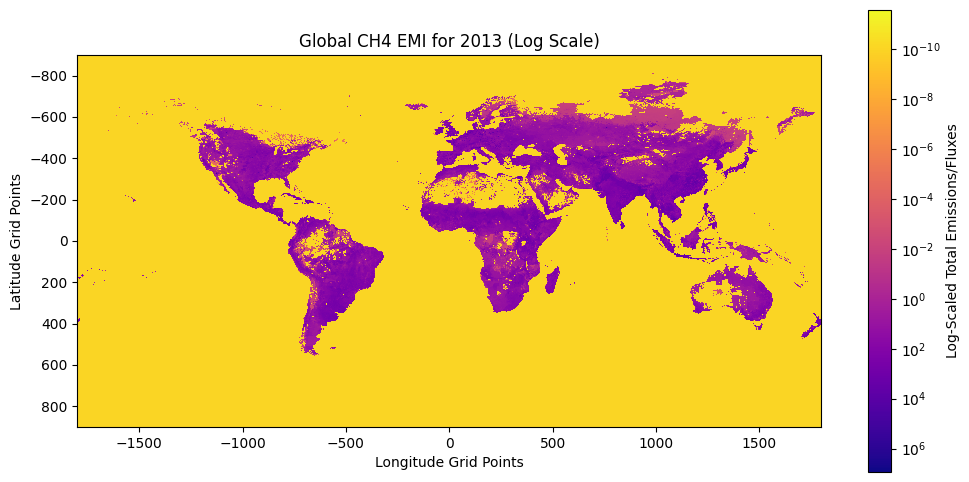

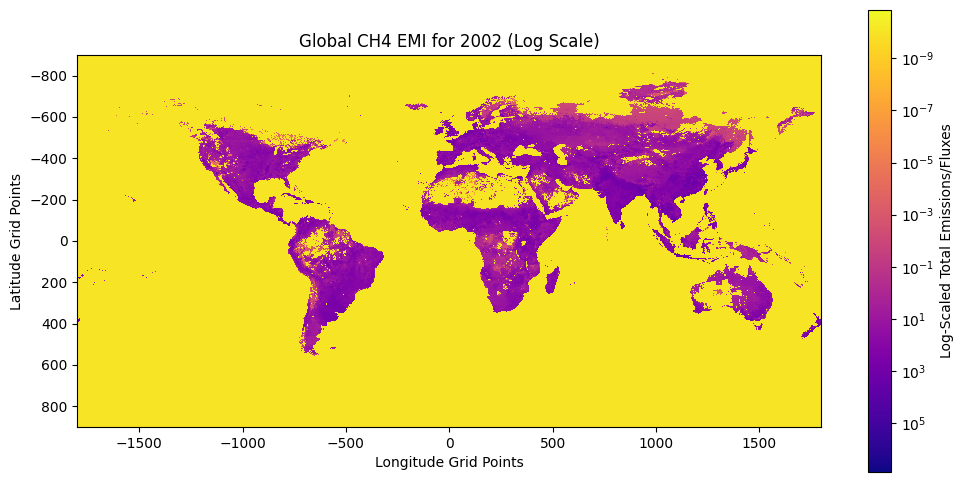

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LogNorm

# Load the memory-mapped tensor
super_tensor_file = os.path.join(current_dir, "super_emissions_tensor.npy")
molecule_types = ["CH4", "CO2", "CO2bio", "GWP", "N2O"]
data_types = ["emi", "flx"]

# Load the super tensor
super_tensor_shape = (5, 2, 288, 1800, 3600)
super_tensor = np.memmap(super_tensor_file, dtype='float32', mode='r', shape=super_tensor_shape)

# Define years
years = list(range(2000, 2024))

# ✅ Function to randomly select and plot emissions/fluxes with normalization and log scaling
def plot_random_emission_or_flux():
    # Random selection
    random_year = random.choice(years)
    random_molecule = random.choice(molecule_types)
    random_data_type = random.choice(data_types)

    # Convert year to tensor indices
    year_index = (random_year - 2000) * 12  # Each year has 12 months
    year_slice = slice(year_index, year_index + 12)

    # Indices for molecule and data type
    molecule_idx = molecule_types.index(random_molecule)
    data_type_idx = data_types.index(random_data_type)

    # Sum across months to get yearly totals
    yearly_data = np.sum(super_tensor[molecule_idx, data_type_idx, year_slice, :, :], axis=0)

    # Normalize the data and apply logarithmic scaling
    yearly_data = np.where(yearly_data == 0, 1e-10, yearly_data)  # Replace zeros for log scale
    norm = LogNorm(vmin=yearly_data.min(), vmax=yearly_data.max())

    # Plot the global emissions/fluxes
    plt.figure(figsize=(12, 6))
    plt.imshow(
        yearly_data,
        cmap='plasma_r',  # Reversed colormap for better visibility
        interpolation='nearest',
        extent=[-1800, 1800, -900, 900],
        norm=norm
    )

    # Add a color bar with proper scaling
    cbar = plt.colorbar(label="Log-Scaled Total Emissions/Fluxes")
    cbar.ax.invert_yaxis()

    # Set plot titles and labels
    plt.title(f"Global {random_molecule} {random_data_type.upper()} for {random_year} (Log Scale)")
    plt.xlabel("Longitude Grid Points")
    plt.ylabel("Latitude Grid Points")
    plt.gca().invert_yaxis()  # Invert latitude axis for correct map orientation
    plt.show()

# 🔥 Plot multiple random visualizations
for _ in range(5):  # Plot 5 random selections
    plot_random_emission_or_flux()


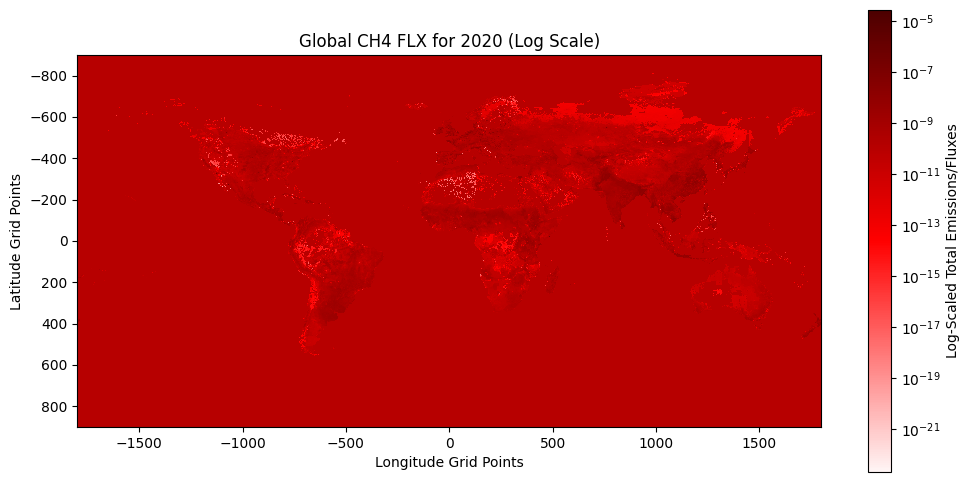

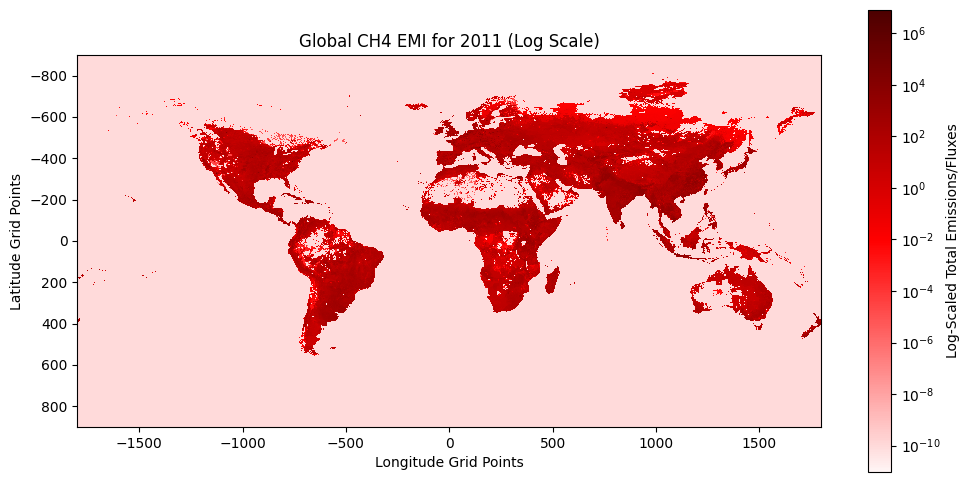

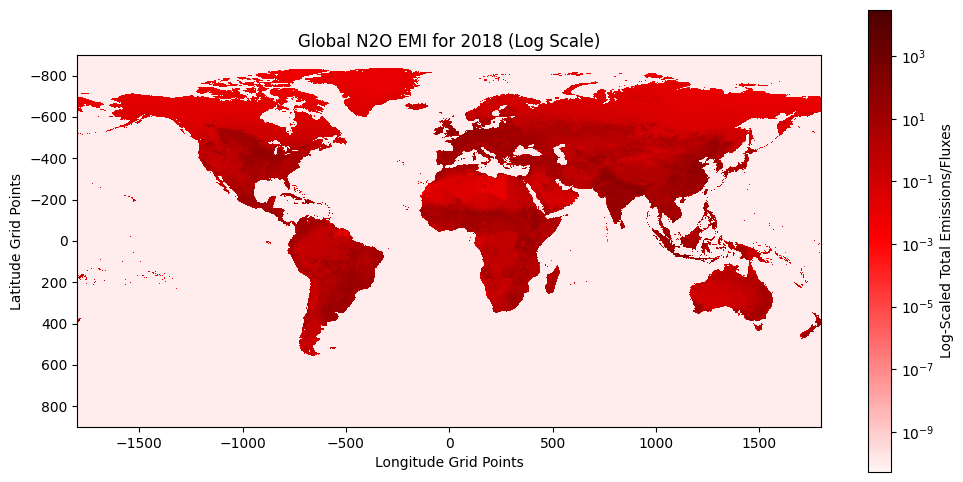

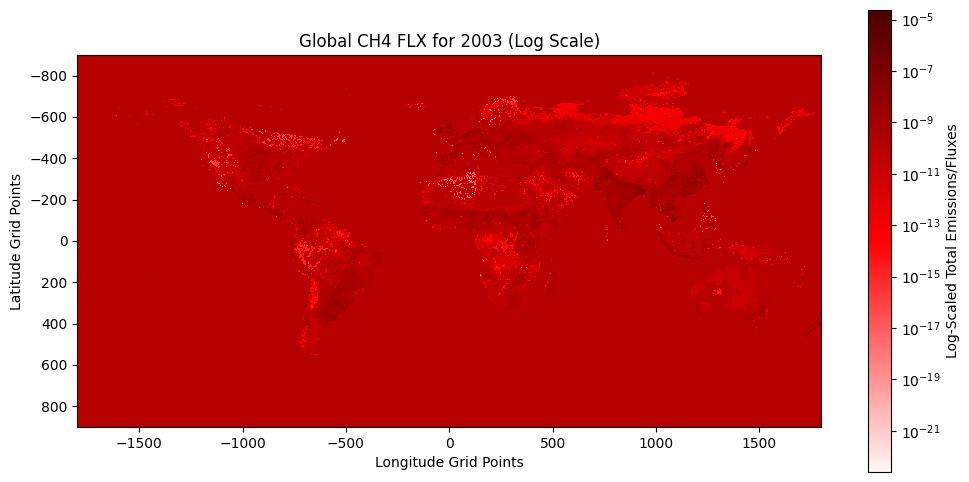

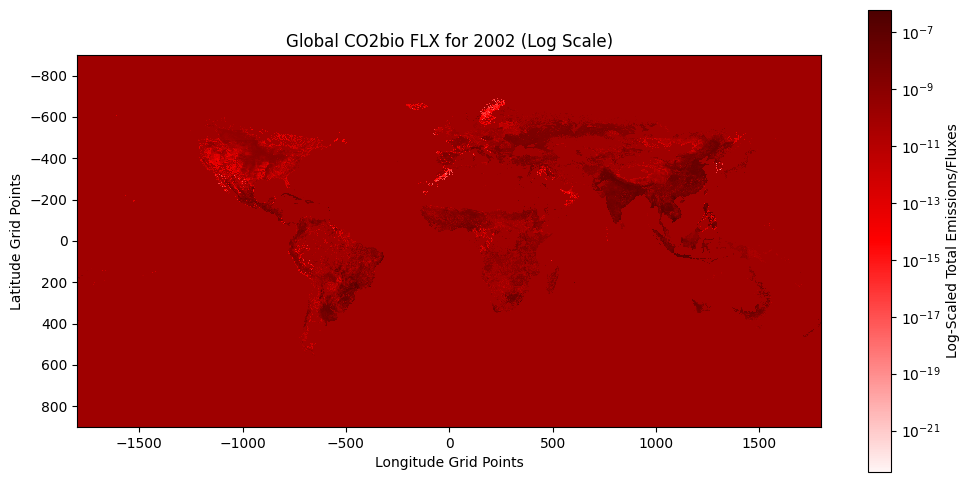

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LogNorm, LinearSegmentedColormap

# Load the memory-mapped tensor
super_tensor_file = os.path.join(current_dir, "super_emissions_tensor.npy")
molecule_types = ["CH4", "CO2", "CO2bio", "GWP", "N2O"]
data_types = ["emi", "flx"]

# Load the super tensor
super_tensor_shape = (5, 2, 288, 1800, 3600)
super_tensor = np.memmap(super_tensor_file, dtype='float32', mode='r', shape=super_tensor_shape)

# Define years
years = list(range(2000, 2024))

# ✅ Custom red-based colormap
red_gradient = LinearSegmentedColormap.from_list("red_gradient", ["#fff5f5", "#ff0000", "#4d0000"])

# ✅ Function to randomly select and plot emissions/fluxes with proper scaling
def plot_random_emission_or_flux():
    # Random selection
    random_year = random.choice(years)
    random_molecule = random.choice(molecule_types)
    random_data_type = random.choice(data_types)

    # Convert year to tensor indices
    year_index = (random_year - 2000) * 12  # Each year has 12 months
    year_slice = slice(year_index, year_index + 12)

    # Indices for molecule and data type
    molecule_idx = molecule_types.index(random_molecule)
    data_type_idx = data_types.index(random_data_type)

    # Sum across months to get yearly totals
    yearly_data = np.sum(super_tensor[molecule_idx, data_type_idx, year_slice, :, :], axis=0)

    # Normalize and apply log scale
    yearly_data = np.where(yearly_data == 0, 1e-10, yearly_data)  # Replace zeros
    norm = LogNorm(vmin=yearly_data.min(), vmax=yearly_data.max())

    # Plot the global emissions/fluxes
    plt.figure(figsize=(12, 6))
    plt.imshow(
        yearly_data,
        cmap=red_gradient,  # Custom red gradient
        interpolation='nearest',
        extent=[-1800, 1800, -900, 900],
        norm=norm
    )

    # Add a color bar without inversion
    cbar = plt.colorbar(label="Log-Scaled Total Emissions/Fluxes")

    # Set plot titles and labels
    plt.title(f"Global {random_molecule} {random_data_type.upper()} for {random_year} (Log Scale)")
    plt.xlabel("Longitude Grid Points")
    plt.ylabel("Latitude Grid Points")
    plt.gca().invert_yaxis()  # Correct orientation
    plt.show()

# 🔥 Plot multiple random visualizations
for _ in range(5):  # Plot 5 random selections
    plot_random_emission_or_flux()


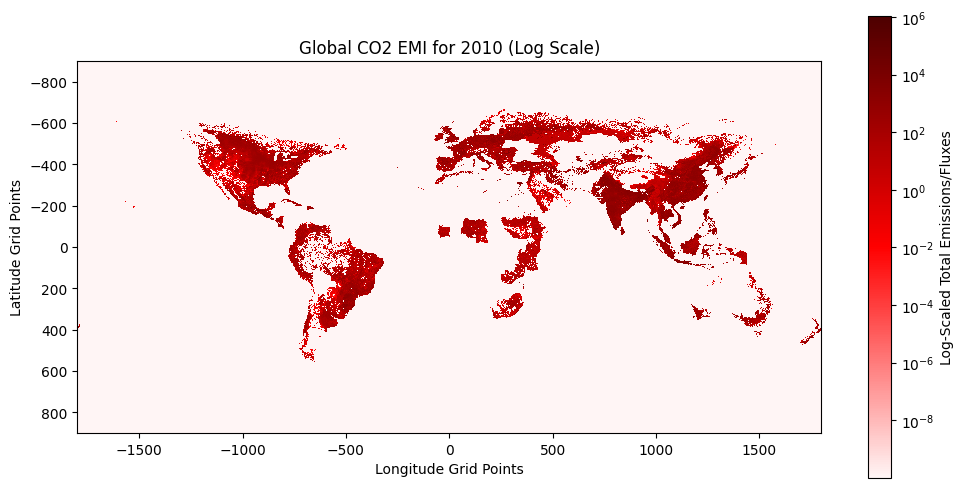

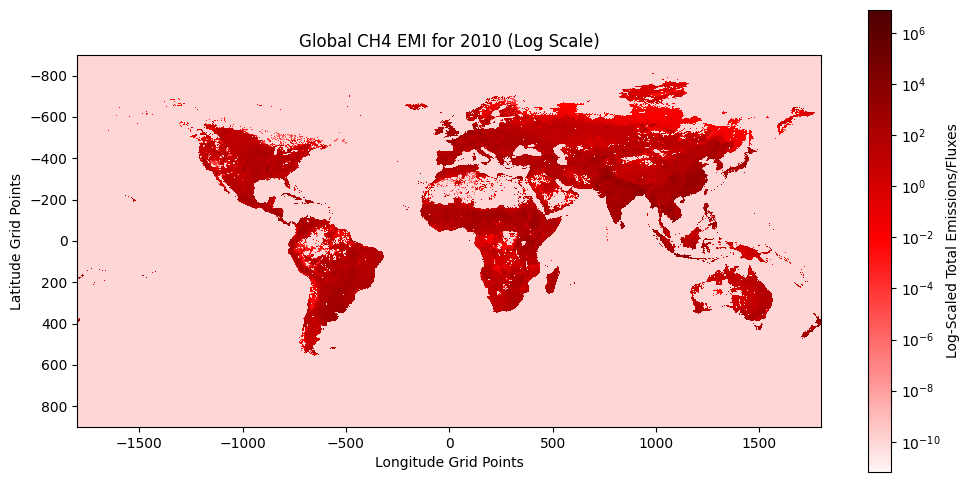

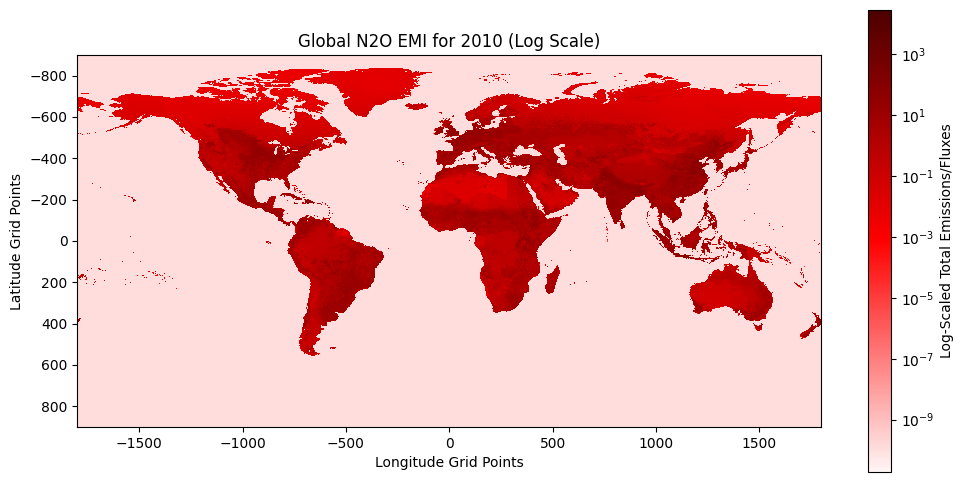

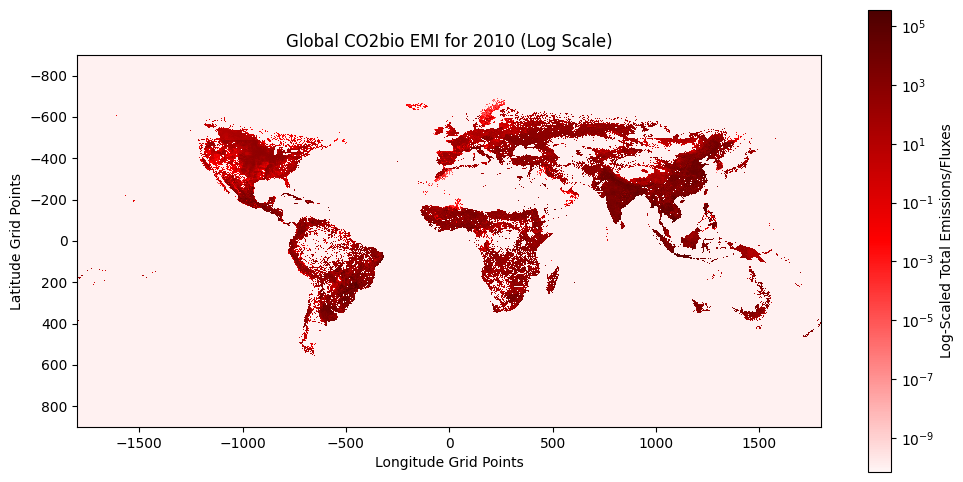

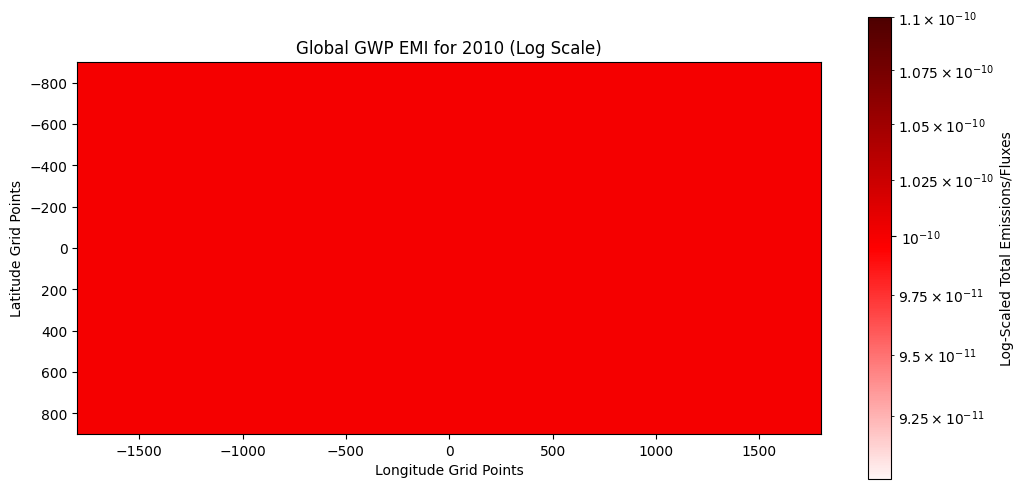

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LogNorm, LinearSegmentedColormap

# ✅ Global Variables and Constants
super_tensor_file = os.path.join(current_dir, "super_emissions_tensor.npy")

# Tensor dimensions and mappings
molecule_types = ["CH4", "CO2", "CO2bio", "GWP", "N2O"]
data_types = ["emi", "flx"]
years = list(range(2000, 2024))

# Load tensors
super_tensor_shape = (5, 2, 288, 1800, 3600)
cropped_tensor_shape = (5, 2, 288, 1400, 3600)

super_tensor = np.memmap(super_tensor_file, dtype='float32', mode='r', shape=super_tensor_shape)

# ✅ Custom red-based colormap
red_gradient = LinearSegmentedColormap.from_list("red_gradient", ["#fff5f5", "#ff0000", "#4d0000"])


# ✅ Helper Functions
def get_yearly_data(tensor, molecule, data_type, year):
    """Extract yearly emissions/flux data for a given molecule, data type, and year."""
    molecule_idx = molecule_types.index(molecule)
    data_type_idx = data_types.index(data_type)

    # Convert year to tensor indices
    year_index = (year - 2000) * 12  # 12 months per year
    year_slice = slice(year_index, year_index + 12)

    # Sum across months to get yearly totals
    yearly_data = np.sum(tensor[molecule_idx, data_type_idx, year_slice, :, :], axis=0)
    yearly_data = np.where(yearly_data == 0, 1e-10, yearly_data)  # Replace zeros for log scale
    return yearly_data


def plot_emission_data(data, title, extent, cmap=red_gradient):
    """Plot the emissions/flux data with proper scaling and formatting."""
    norm = LogNorm(vmin=data.min(), vmax=data.max())

    plt.figure(figsize=(12, 6))
    plt.imshow(
        data,
        cmap=cmap,
        interpolation='nearest',
        extent=extent,
        norm=norm
    )
    cbar = plt.colorbar(label="Log-Scaled Total Emissions/Fluxes")

    plt.title(title)
    plt.xlabel("Longitude Grid Points")
    plt.ylabel("Latitude Grid Points")
    plt.gca().invert_yaxis()  # Correct orientation
    plt.show()


def plot_specific_emission(tensor, molecule, data_type, year, extent):
    """Plot specific molecule, data type, and year from the tensor."""
    yearly_data = get_yearly_data(tensor, molecule, data_type, year)
    title = f"Global {molecule} {data_type.upper()} for {year} (Log Scale)"
    plot_emission_data(yearly_data, title, extent)



# Plot a specific example (CO2 emissions for 2010 from the full tensor)
plot_specific_emission(super_tensor, "CO2", "emi", 2010, extent=[-1800, 1800, -900, 900])
plot_specific_emission(super_tensor, "CH4", "emi", 2010, extent=[-1800, 1800, -900, 900])
plot_specific_emission(super_tensor, "N2O", "emi", 2010, extent=[-1800, 1800, -900, 900])
plot_specific_emission(super_tensor, "CO2bio", "emi", 2010, extent=[-1800, 1800, -900, 900])
plot_specific_emission(super_tensor, "GWP", "emi", 2010, extent=[-1800, 1800, -900, 900])




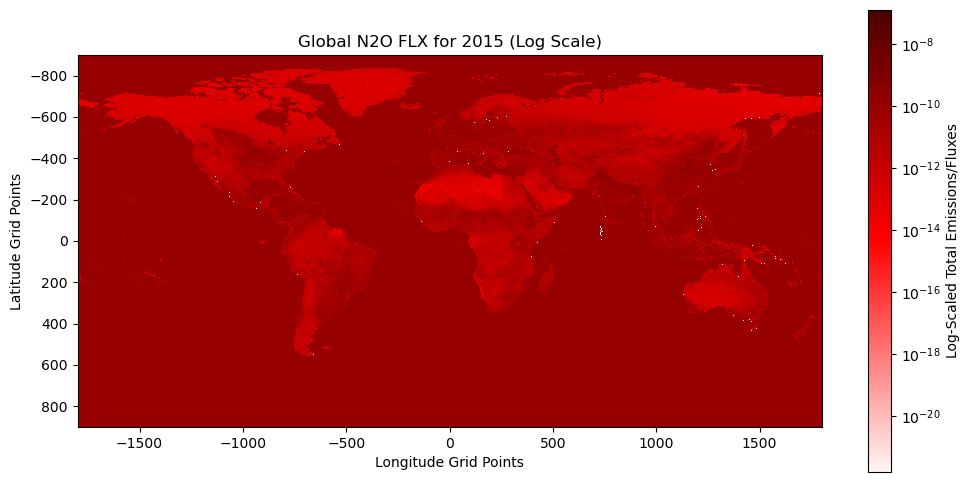

In [32]:
plot_specific_emission(super_tensor, "N2O", "flx", 2015, extent=[-1800, 1800, -900, 900])